In [185]:
import math

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from utilities.storage import get_dot_product_bm25_selected_files

In [186]:
model_to_evaluate = "amd/AMD-OLMo-1B-SFT"
sample_size = 100

#model_to_evaluate = "openai-community/gpt2"
#sample_size = 3

In [187]:
dot_products, paraphrased_dot_products, original_dot_products = get_dot_product_bm25_selected_files(model_to_evaluate, sample_size)

In [188]:
def calculate_cosine_similarity(a_dot_b, a_dot_a, b_dot_b):
    return a_dot_b / (math.sqrt(a_dot_a) * math.sqrt(b_dot_b))

In [189]:
cosine_similarities_old_structure = dict()

# restructure such that layer is at outermost level in the dictionary for easier access afterwards
cosine_similarities_new_structure = dict()

for paraphrased_id, values in dot_products.items():
    cosine_similarities_old_structure[paraphrased_id] = dict()
    for original_id, layers in values.items():

        cosine_similarities_old_structure[paraphrased_id][original_id] = dict()

        for layer, value in layers.items():
            if layer not in cosine_similarities_new_structure:
                cosine_similarities_new_structure[layer] = dict()

            if paraphrased_id not in cosine_similarities_new_structure[layer]:
                cosine_similarities_new_structure[layer][paraphrased_id] = dict()

            cosine_similarity = calculate_cosine_similarity(value, paraphrased_dot_products[paraphrased_id][layer], original_dot_products[original_id][layer])

            cosine_similarities_old_structure[paraphrased_id][original_id][layer] = cosine_similarity
            cosine_similarities_new_structure[layer][paraphrased_id][original_id] = cosine_similarity

In [190]:
# check if restructuring has worked by comparing iteratively with gradient_similarities dictionary
for layer, values in cosine_similarities_new_structure.items():
    for paraphrased_id, original_ids in values.items():
        for original_id, similarity in original_ids.items():
            assert similarity == cosine_similarities_old_structure[paraphrased_id][original_id][layer]

In [191]:
correct_counter_per_layer = defaultdict(int)

# amount of paraphrased_samples
size = len(next(iter(cosine_similarities_new_structure.values())).keys())

for layer, values in cosine_similarities_new_structure.items():
    for paraphrased_id, original_ids in values.items():
        most_similar_original_id = max(original_ids, key=original_ids.get)
        correct_counter_per_layer[layer] += int(paraphrased_id == most_similar_original_id)

    # divide by size to get percentage
    correct_counter_per_layer[layer] /= size


In [193]:
for layer, percentage in correct_counter_per_layer.items():
    if percentage < 1:
        print(f"Layer {layer} has a percentage of {percentage}")

Layer model.layers.0.self_attn.q_proj.weight has a percentage of 0.99
Layer model.layers.0.self_attn.k_proj.weight has a percentage of 0.98
Layer model.layers.1.self_attn.q_proj.weight has a percentage of 0.99
Layer model.layers.1.self_attn.k_proj.weight has a percentage of 0.97
Layer model.layers.2.self_attn.q_proj.weight has a percentage of 0.99
Layer model.layers.2.self_attn.k_proj.weight has a percentage of 0.95
Layer model.layers.2.self_attn.v_proj.weight has a percentage of 0.99
Layer model.layers.3.self_attn.k_proj.weight has a percentage of 0.9
Layer model.layers.3.self_attn.v_proj.weight has a percentage of 0.99
Layer model.layers.4.self_attn.k_proj.weight has a percentage of 0.96
Layer model.layers.5.self_attn.k_proj.weight has a percentage of 0.97
Layer model.layers.6.self_attn.k_proj.weight has a percentage of 0.97
Layer model.layers.7.self_attn.k_proj.weight has a percentage of 0.96
Layer model.layers.10.self_attn.k_proj.weight has a percentage of 0.96
Layer model.layers.1

[]

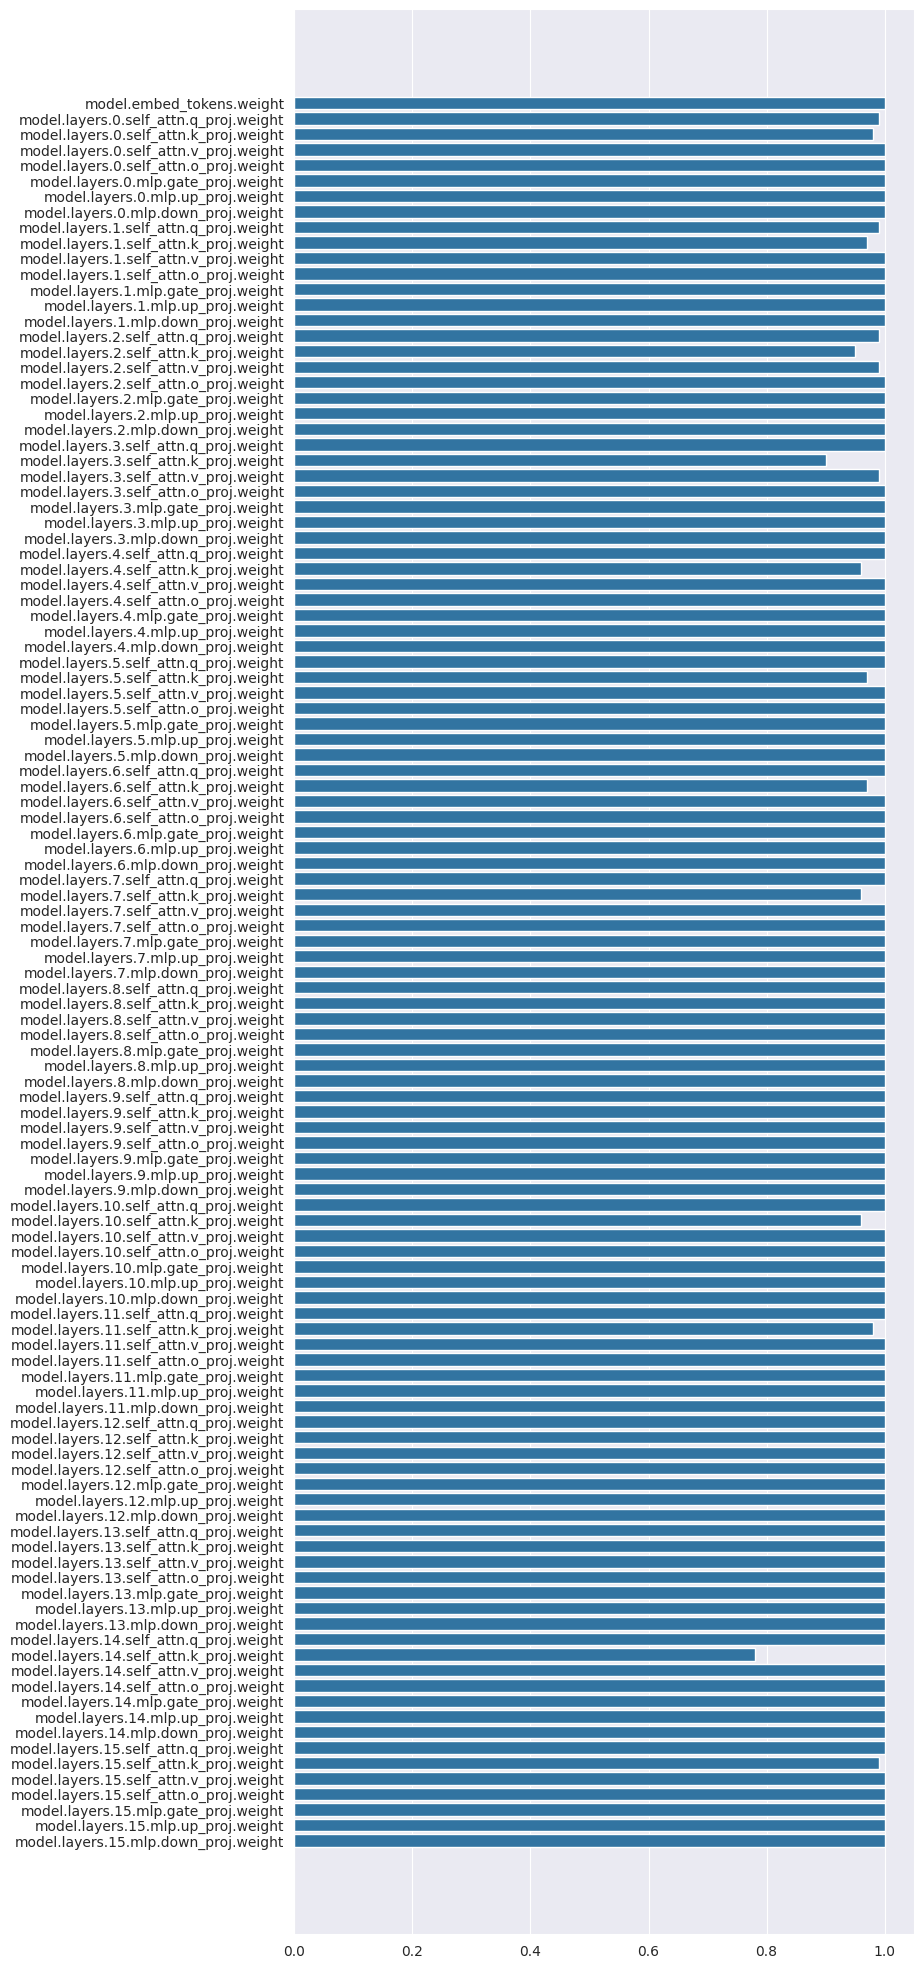

In [192]:
plt.figure(figsize=(8, 25))
sns.barplot(y = list(correct_counter_per_layer.keys()), x = list(correct_counter_per_layer.values()), orient="h")
plt.plot()